In [2]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-championstweet")):
    res = es.indices.create(index="tp5-championstweet")  
    pprint(res)                    

In [3]:
# 
import json
import os
files = os.listdir("split_dataset_1")
pprint(len(files))

354585


In [5]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('split_dataset_1/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tp5-championstweet", doc_type="_doc")
        tweets=[]

KeyboardInterrupt: 

In [17]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body=
               {
  "query": {
    "bool" : {
      "must" : [
          {"term" : { "text" : "liverpool" }},
           {"term" : { "location" : "chile" }}
          
          ]}}}
               )
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print(hit)

Got 93 Hits:
{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'dIE2gWQBTzobNLdbfSE4', '_score': 9.6117325, '_source': {'timestamp': 1527361742091, 'date': 'Sat May 26 19:09:02 +0000 2018', 'text': 'Casi casi, vamos Liverpool #ChampionsLeagueFinal #UCLfinal', 'username': 'nachosky🐍', 'location': 'chile'}}
{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'oYI3gWQBTzobNLdbgF66', '_score': 9.580116, '_source': {'timestamp': 1527361551844, 'date': 'Sat May 26 19:05:51 +0000 2018', 'text': 'Extraordinario el aliento del Liverpool ! #UCLfinal', 'username': 'F. Sullivan McLair🚀', 'location': 'Chile'}}
{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'sYE3gWQBTzobNLdbJe5h', '_score': 9.488091, '_source': {'timestamp': 1527366526066, 'date': 'Sat May 26 20:28:46 +0000 2018', 'text': 'El arquero del #Liverpool es como el loli #UCLfinal', 'username': 'Marcelo Córdova', 'location': 'Chile'}}
{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'aoE2gWQBTzobNLdb7qnU', '_s

In [53]:
res['aggregations']['tweets_over_time']['buckets']

[{'key': 1527340680000, 'doc_count': 8},
 {'key': 1527340740000, 'doc_count': 0},
 {'key': 1527340800000, 'doc_count': 0},
 {'key': 1527340860000, 'doc_count': 0},
 {'key': 1527340920000, 'doc_count': 0},
 {'key': 1527340980000, 'doc_count': 0},
 {'key': 1527341040000, 'doc_count': 0},
 {'key': 1527341100000, 'doc_count': 0},
 {'key': 1527341160000, 'doc_count': 0},
 {'key': 1527341220000, 'doc_count': 0},
 {'key': 1527341280000, 'doc_count': 0},
 {'key': 1527341340000, 'doc_count': 0},
 {'key': 1527341400000, 'doc_count': 0},
 {'key': 1527341460000, 'doc_count': 0},
 {'key': 1527341520000, 'doc_count': 0},
 {'key': 1527341580000, 'doc_count': 0},
 {'key': 1527341640000, 'doc_count': 0},
 {'key': 1527341700000, 'doc_count': 0},
 {'key': 1527341760000, 'doc_count': 0},
 {'key': 1527341820000, 'doc_count': 0},
 {'key': 1527341880000, 'doc_count': 0},
 {'key': 1527341940000, 'doc_count': 0},
 {'key': 1527342000000, 'doc_count': 0},
 {'key': 1527342060000, 'doc_count': 8},
 {'key': 1527342

In [48]:
#CONSULTA: ¿Cuántos tweets cada minuto?
res = es.search(index="tp5-championstweet", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
#for data in res['aggregations']['tweets_over_time']['buckets']:
#    print(data['doc_count'])

In [49]:
import pandas as pd

df_tweetsByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_tweetsByMinutes = df_tweetsByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_tweetsByMinutes[:10]

,nb_tweets,timestamp
0,8,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [54]:
df_tweetsByMinutes_filtered = df_tweetsByMinutes.drop(df_tweetsByMinutes[df_tweetsByMinutes.timestamp < 1527357600000 ].index)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,1527357600000
283,0,1527357660000
284,0,1527357720000
285,0,1527357780000
286,0,1527357840000
287,0,1527357900000
288,0,1527357960000
289,0,1527358020000
290,0,1527358080000
291,0,1527358140000


In [55]:
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_tweetsByMinutes_filtered['timestamp']=df_tweetsByMinutes_filtered['timestamp'].apply(timestamp2date)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,14:00:00
283,0,14:01:00
284,0,14:02:00
285,0,14:03:00
286,0,14:04:00
287,0,14:05:00
288,0,14:06:00
289,0,14:07:00
290,0,14:08:00
291,0,14:09:00


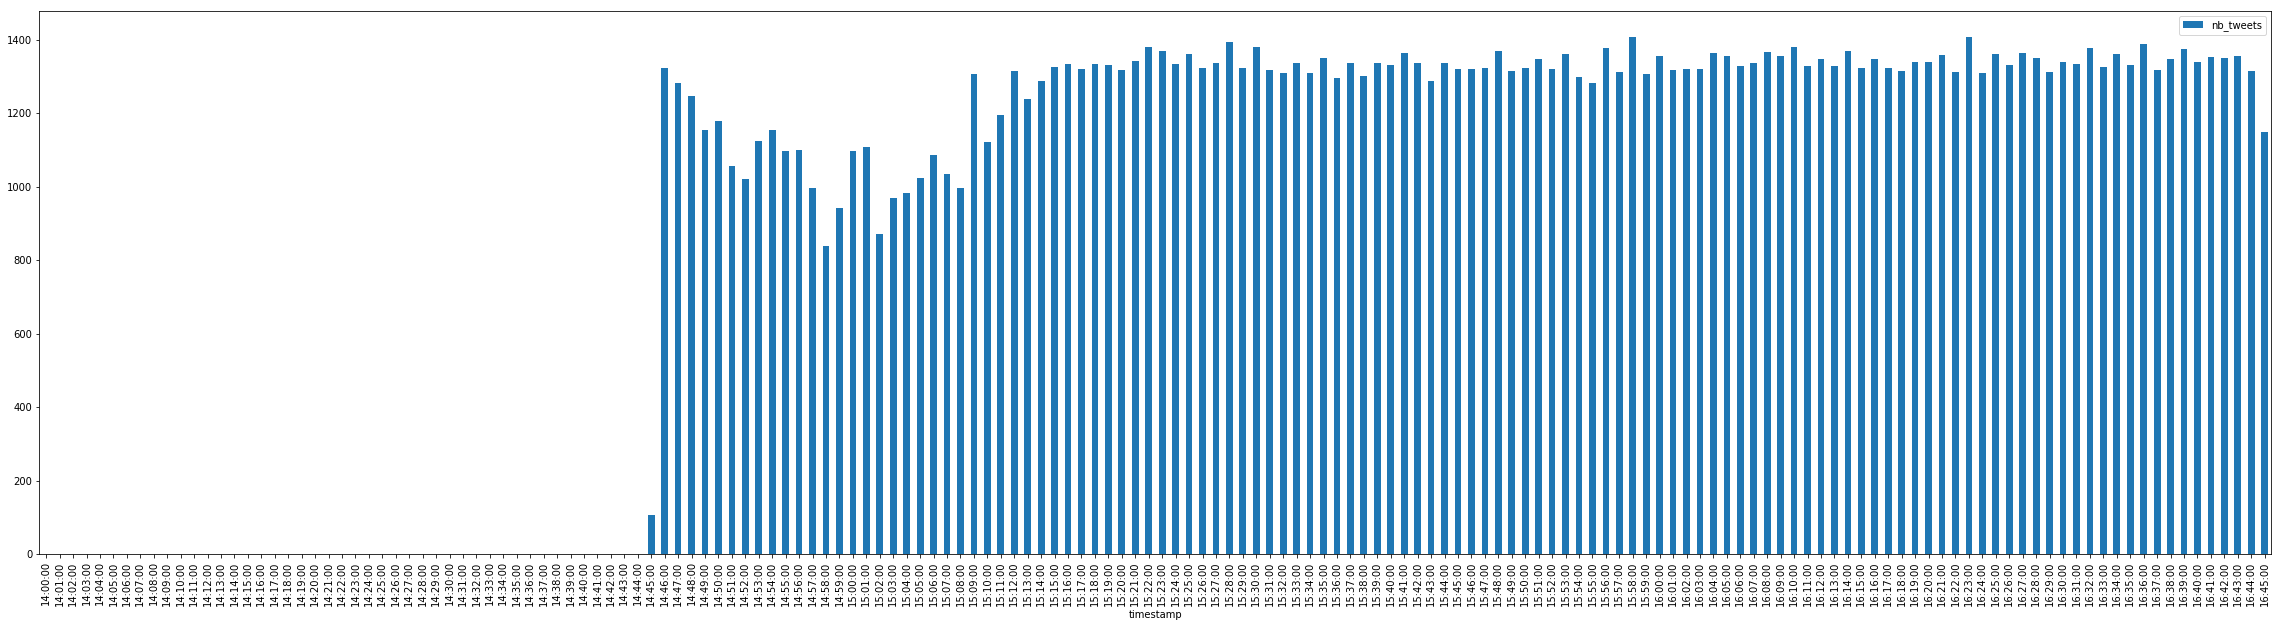

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

df_tweetsByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [57]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"term":{"text":"goal"}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

Got 7326 Hits:
TWEET:Super goal goal goal goal goal https://t.co/FVh1CVOEGA Abouuuuuuuuuuuuu Impala: Sat May 26 20:12:56 +0000 2018
TWEET:GOAL GOAL GOAL GOAL GOOOAAAAL MANEEEEE #UCLFinal NooR: Sat May 26 20:01:07 +0000 2018
TWEET:Goal! Goal!! Goal!!! Sadio Mane #UCLfinal P!: Sat May 26 20:00:31 +0000 2018
TWEET:#UCLfinal

Never felt this alive. Goal goal goal Gagan: Sat May 26 20:01:30 +0000 2018
TWEET:#UCLfinal

Never felt this alive. Goal goal goal Gagan: Sat May 26 20:01:30 +0000 2018
TWEET:#UCLfinal

Never felt this alive. Goal goal goal Gagan: Sat May 26 20:01:30 +0000 2018
TWEET:Mane goal issa goal #uclfinal A Y O👑: Sat May 26 20:00:59 +0000 2018
TWEET:#UCLfinal 
Goal Na Goal 🌚 https://t.co/ANTZTqRI4S misleadteenager: Sat May 26 20:04:24 +0000 2018
TWEET:One crazy goal, one fantastic goal. #UCLfinal Lawrence: Sat May 26 20:12:59 +0000 2018
TWEET:Wasee wa Goal-Goal meanwhile nip safe.
#UCLFinal Joe: Sat May 26 20:06:02 +0000 2018
